## Disclaimer and acknowledgement

Author:  H. NIU

July 21, 2021 

The notebook was partly borrowed, adpated and function-added for needs  from https://github.com/IntelliHQ/CardiacArrestMortality_ANZICS, which holds the copyright and credits on that code. This is acknowledged the LICENSE with that repo is not copied along. I greatly appreciate the authors of that code for their efforts. 

In [1]:
!python -V

Python 3.7.3


In [3]:
import pickle
import random
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
import matplotlib

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score,make_scorer
#from sklearn.metrics.scorer import make_scorer

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('sklearn version:', sklearn.__version__)
print('matplotlib version:', matplotlib.__version__)

Numpy version: 1.18.0
Pandas version: 0.25.1
sklearn version: 0.24.0
matplotlib version: 3.4.3


In [4]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

#scikit-learn package (https://pypi.org/project/scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
#from sklearn.metrics.scorer import make_scorer

#eli5 package (https://eli5.readthedocs.io/en/latest)
import eli5
from eli5.sklearn import PermutationImportance

#lime package (https://github.com/marcotcr/lime)
import lime
import lime.lime_tabular

#shap package (https://github.com/slundberg/shap)
import shap

In [5]:
# %matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 18

## Making machine learning pipleline

LIME explainers take in the original raw data for model explanation (for human understandable explainations), so the target model has to include the preprocessing steps. So the following pipleline is largely a repeat of what's done in the preprocessing and omitting the model fitting steps.

In [6]:
df = pd.read_excel(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Data\150CA_EN20210701.xlsx')

df.head()

,Gender,Age_value,BMI_value,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA_PS,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage_ml,Blood_transfusion_ml,Epinephrine_mg,Atropine_mg,Amiodarone_g,Ephedrine_mg,Methoxamine_mg,CPR_min,Died
0,Female,46.0,23.738662,0,0,0,0,0,0,1,0,Abdominal,0,0,General,Supine,2,Intubation,0,Anesthesia,0,0,0.00,0.0,0.00,0.0,0.0,0.16,0
1,Male,72.0,24.341758,0,0,0,0,0,0,0,0,Thoracic,0,0,General,Right lateral decubitus,2,Surgery,1,Unknown,1000,650,25.30,0.0,0.30,0.0,0.0,125.00,1
2,Male,56.0,24.034610,0,0,0,0,0,0,0,1,Neurosurgery,0,0,General,Left lateral decubitus,2,Surgery,1,Surgery,150,0,0.03,0.0,0.15,0.0,0.0,21.00,0
3,Female,64.0,29.048656,0,0,0,0,0,0,0,0,Abdominal,0,0,General,Supine,2,Surgery,0,Anesthesia,200,0,0.00,0.0,0.00,0.0,0.0,0.50,0
4,Male,68.0,28.081633,0,0,0,0,0,0,0,0,Abdominal,1,0,General,Supine,3,Surgery,1,Surgery,0,0,7.50,0.0,0.00,6.0,0.0,180.00,1


In [7]:
df['Age']='<12'
#df['Age']='>=65'
df.loc[(df['Age_value'] >= 12) & (df['Age_value'] < 40), 'Age'] = '12~40'
#df.loc[(df['Age_value'] < 40), 'Age'] = '<40'
df.loc[(df['Age_value'] >= 40) & (df['Age_value'] < 65), 'Age'] = '40~65'
df.loc[(df['Age_value'] >= 65), 'Age'] = '>=65'
#df.loc[(df['Age_value'] <=5), 'Age'] = '<=5'

df['BMI']='Underweight'
df.loc[(df['BMI_value'] >= 19) & (df['BMI_value'] < 24), 'BMI'] = 'Ideal'
df.loc[(df['BMI_value'] >= 24) & (df['BMI_value'] < 28), 'BMI'] = 'Overweight'
df.loc[(df['BMI_value'] >= 28), 'BMI'] = 'Obese'

df['ASA']='I-III'
df.loc[(df['ASA_PS'] >= 4), 'ASA'] = 'IV-V'


#df['Hemorrhage']='0'
df['Hemorrhage'] = '<200'
df.loc[(df['Hemorrhage_ml'] >= 200) & (df['Hemorrhage_ml'] < 800), 'Hemorrhage'] = '200~800'
df.loc[(df['Hemorrhage_ml'] >= 800), 'Hemorrhage'] = '>=800'

#df['Blood_transfusion']='0'
df['Blood_transfusion'] = '<200'
df.loc[(df['Blood_transfusion_ml'] >= 200) & (df['Blood_transfusion_ml'] < 800), 'Blood_transfusion'] = '200~800'
df.loc[(df['Blood_transfusion_ml'] >= 800), 'Blood_transfusion'] = '>=800'

df['Epinephrine']='0'
df.loc[(df['Epinephrine_mg'] > 0) & (df['Epinephrine_mg'] <= 5), 'Epinephrine'] = '<=5'
df.loc[(df['Epinephrine_mg'] > 5), 'Epinephrine'] = '>5'

df['Atropine']='0'
df.loc[(df['Atropine_mg'] > 0) & (df['Atropine_mg'] <= 0.65), 'Atropine'] = '<=0.65'
df.loc[(df['Atropine_mg'] > 0.65), 'Atropine'] = '>0.65'

df['Amiodarone']='0'
#df.loc[(df['Amiodarone_g'] > 0) & (df['Amiodarone_g'] <= 0.11), 'Amiodarone'] = '<=0.11'
df.loc[(df['Amiodarone_g'] > 0), 'Amiodarone'] = '0.04~0.3'
        
df['Ephedrine']='0'
#df.loc[(df['Ephedrine_mg'] > 0) & (df['Ephedrine_mg'] <= 6), 'Ephedrine'] = '<=6'
df.loc[(df['Ephedrine_mg'] > 0), 'Ephedrine'] = '6~15'
        
df['Methoxamine']='0'
#df.loc[(df['Methoxamine_mg'] > 0) & (df['Methoxamine_mg'] <= 3), 'Methoxamine'] = '<=3'
df.loc[(df['Methoxamine_mg'] > 0), 'Methoxamine'] = '1~35'
   
#df['CPR']='0'
#df.loc[(df['CPR_min'] > 0) & (df['CPR_min'] < 30), 'CPR'] = '<=30'
df.loc[(df['CPR_min'] < 30), 'CPR'] = '<30'
df.loc[(df['CPR_min'] >= 30) & (df['CPR_min'] < 60), 'CPR'] = '30~60'
df.loc[(df['CPR_min'] >= 60), 'CPR'] = '>=60'


df2=df[["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]]

df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 29 columns):
Gender                      150 non-null object
Age                         150 non-null object
BMI                         150 non-null object
Comorbidity_diabetes        150 non-null int64
Comorbidity_hypertension    150 non-null int64
Comorbidity_CAD             150 non-null int64
Comorbidity_pulmonary       150 non-null int64
Comorbidity_hepatic         150 non-null int64
Comorbidity_renal           150 non-null int64
Comorbidity_neurological    150 non-null int64
Comorbidity_tumor           150 non-null int64
Surgical_type               150 non-null object
Emergency                   150 non-null int64
Trauma                      150 non-null int64
Anaesthetic_type            150 non-null object
Operative_position          150 non-null object
ASA                         150 non-null object
Timing_arrest               150 non-null object
Defibrillate                150 non-null 

In [8]:
df=df2
X=df
X['Gender'] = X.Gender.map({'Male':1, 'Female':0}) # M -> 1, F -> 0
X['Age'] = X.Age.map({'<12':0,'12~40':1,'40~65':2,'>=65':3}) # 
X['BMI'] = X.BMI.map({'Underweight':0, 'Ideal':1,'Overweight':2,'Obese':3}) # 
X['ASA'] = X.ASA.map({'I-III':0, 'IV-V':1}) # 
X['Hemorrhage'] = X.Hemorrhage.map({'<200':0, '200~800':1,'>=800':2}) # 
X['Blood_transfusion'] = X.Blood_transfusion.map({'<200':0, '200~800':1,'>=800':2}) # 
X['Epinephrine'] = X.Epinephrine.map({'0':0, '<=5':1,'>5':2}) # 
X['Atropine'] = X.Atropine.map({'0':0, '<=0.65':1,'>0.65':2}) # 
X['Amiodarone'] = X.Amiodarone.map({'0':0, '0.04~0.3':1}) # 
X['Ephedrine'] = X.Ephedrine.map({'0':0, '6~15':1}) # 
X['Methoxamine'] = X.Methoxamine.map({'0':0, '1~35':1}) # 
X['CPR'] = X.CPR.map({'<30':0,'30~60':1,'>=60':2}) # 
X['Surgical_type'] = X.Surgical_type.map({'Abdominal':0, 'Neurosurgery':1,'Orthopedics':2,'Thoracic':3,'Throat':4,'Others':5}) 
        # Abdominal->0, Neurosurgery->1,Thoracic->3,Throat->4,Others->5
X['Anaesthetic_type'] = X.Anaesthetic_type.map({'General':1, 'Local':0}) # General -> 1, Local -> 0
X['Operative_position'] = X.Operative_position.map({'Left lateral decubitus':0, 'Right lateral decubitus':1,'Prone':2,
                                                           'Lithotomy':3,'Supine':4}) # 
X['Timing_arrest'] = X.Timing_arrest.map({'Induction':0, 'Intubation':1,'Surgery':2,'NotAvaliable':3}) #
X['Cause_arrest'] = X.Cause_arrest.map({'Anesthesia':0, 'Comorbidity':1,'Surgery':2,'Unknown':3}) # M -> 1, F -> 0
df=X

In [9]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
#Now split the data into training and test set(85-15 split)
data_train, data_test = train_test_split(df, test_size=.25,
                                         stratify=df.Gender, random_state=0)

In [11]:
data_train.head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR,Died
85,1,2,1,0,1,0,0,0,1,0,0,0,1,0,1,4,1,0,1,0,0,0,1,0,0,0,0,1,1
105,0,2,3,0,0,0,0,0,0,0,1,0,1,0,1,4,1,2,0,2,2,2,1,0,0,1,0,1,1
65,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,4,1,3,0,3,1,0,0,0,0,0,0,1,0
142,1,2,3,0,1,1,1,0,1,1,0,3,1,0,1,4,1,2,1,1,2,2,1,2,0,0,0,1,1
149,1,2,2,0,1,1,1,1,1,0,0,0,1,0,1,4,1,2,0,1,0,0,2,0,0,0,0,1,1


### Data preprocessing

In [12]:
categorical_vars = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR"]

categorical_var_idxs = [idx for idx, _ in enumerate(list(data_train.columns)) if _ in categorical_vars]
print(categorical_var_idxs) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [13]:
categorical_vars2 = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]

categorical_var_idxs2 = [idx for idx, _ in enumerate(list(data_train.columns)) if _ in categorical_vars2]
print(categorical_var_idxs2) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [14]:
# to make a custom transformer to fit into a pipeline
class Vars_selector(BaseEstimator, TransformerMixin):
    '''Return a subset of variables in a numpy array based on indecies'''
    def __init__(self, var_idxs):
        '''var_idxs is a list of categorical variables indecies'''
        self.var_idxs = var_idxs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''returns a dataframe with selected variables'''
        return np.array(X)[:, self.var_idxs]

In [15]:
class Cat_vars_encoder(BaseEstimator, TransformerMixin):
    '''Return the transformed categorical variables based on indecies'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # arf column index
        # arf_idx = categorical_vars.index('arf')
        # X[:, arf_idx] = np.array(pd.Series(X[:, arf_idx]).map({1:1, 2:0})) # 1 -> Yes(1), 2 -> No(0)
        return X

#### Transform data in a pipeline

In [16]:
# categorical variables preprocessing
cat_vars_pipeline = Pipeline([
    ('selector', Vars_selector(categorical_var_idxs)),
    ('encoder', Cat_vars_encoder())
])

In [17]:
# categorical variables preprocessing
cat_vars_pipeline2 = Pipeline([
    ('selector', Vars_selector(categorical_var_idxs2)),
    ('encoder', Cat_vars_encoder())
])

In [18]:
continuous_vars = [] #['Age', 'BMI', 'Hemorrhage_ml', 'Blood_transfusion', 'Epinephrine_mg', 'Atropine_mg',
       #'Amiodarone_g', 'Ephedrine_mg', 'Methoxamine_mg', 'CPR_min']

To transform the variables in one step.

In [19]:
preproc_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline)
    #,('cont_pipeline', cont_vars_pipeline)
])


preproc_pipeline2 = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline2)
    #,('cont_pipeline', cont_vars_pipeline)
])

In [20]:
data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            columns=categorical_vars + continuous_vars)

data_train_X2 = pd.DataFrame(preproc_pipeline2.fit_transform(data_train), 
                            columns=categorical_vars2 + continuous_vars)

In [21]:
data_test_X = pd.DataFrame(preproc_pipeline2.fit_transform(data_test), 
                            columns=categorical_vars2 + continuous_vars)

data_test_X.head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR,Died
0,0,2,0,0,0,1,1,0,0,1,0,3,1,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0
1,0,1,1,0,0,0,0,0,0,0,0,5,0,0,1,4,0,2,0,3,2,2,1,0,0,0,0,1,0
2,0,2,2,0,0,0,0,0,0,0,1,3,0,0,1,4,1,0,1,1,0,0,1,0,1,0,0,2,1
3,0,1,2,0,1,1,1,0,0,0,0,0,1,0,1,4,1,2,0,1,1,0,2,1,0,0,0,2,1
4,1,2,2,0,1,1,0,0,0,0,0,3,1,0,1,4,1,2,0,2,2,2,2,0,0,0,0,1,1


In [22]:
print(data_train_X2.shape)

(112, 29)


## Making explanation

### 1. A feature importance explainer
https://machinelearningmastery.com/calculate-feature-importance-with-python/

To restore the models and fit them into pipeline.

In [23]:
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'rb') as f:
    rf_clf = pickle.load(f)
model=rf_clf

In [24]:
#data=data_train.drop('Died',1)
data=data_train_X

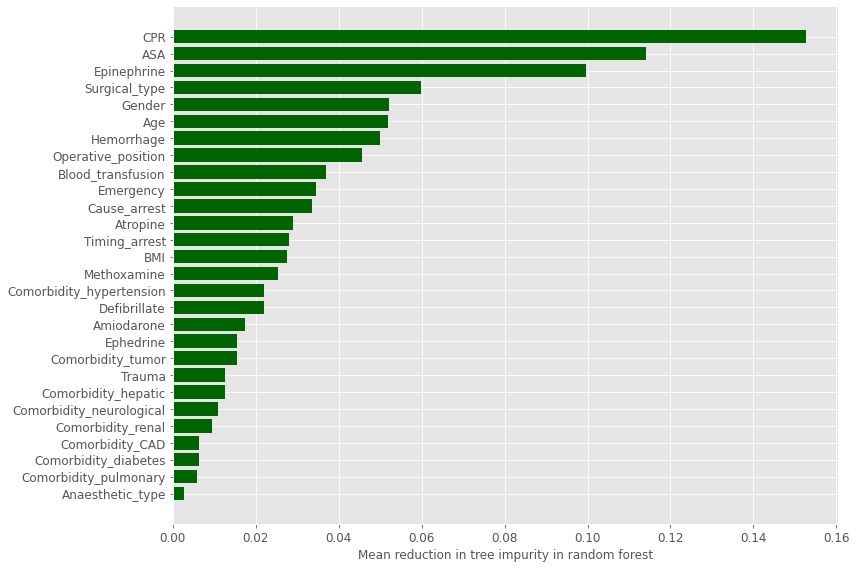

In [25]:
import matplotlib.patches as patches
import matplotlib.colors as colors
import math


# Feature importance dataframe
imp_df = pd.DataFrame({'feature': data.columns.values,
                       'importance': model.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, color='darkgreen')
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in random forest")

plt.tight_layout()

        
# Show graphic
plt.show()

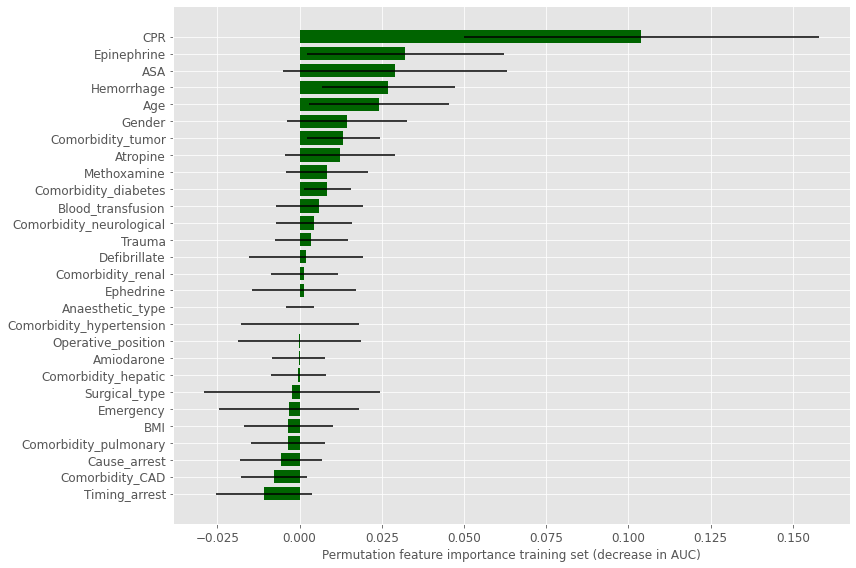

In [26]:
# Feature importance based on TRAINING set

perm_test = PermutationImportance(model, scoring=make_scorer(roc_auc_score),
                                   n_iter=50, random_state=0, cv="prefit")

# fit and see the permuation importances
perm_test.fit(data, data_train['Died'])

imp_df = eli5.explain_weights_df(perm_test)
label_df = pd.DataFrame({'feature': [ "x" + str(i) for i in range(len(data.columns))], 'feature_name': data.columns.values})
imp_df = pd.merge(label_df, imp_df, on='feature', how='inner', validate="one_to_one")
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='weight')
imp_range=range(1,len(imp_df.index)+1)
 

## Barplot with confidence intervals

height = ordered_df['weight']
bars = ordered_df['feature_name']
ci = 1.96 * ordered_df['std']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, xerr=ci, color='darkgreen')
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Permutation feature importance training set (decrease in AUC)")
plt.tight_layout()

# Show graphic
plt.show()


### 2. Preparing a LIME explainer


To restore the models and fit them into pipeline.

In [27]:
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\ensemble_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)

In [28]:
## for ensemble_clf:
class Ensemble_clf(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return ensemble_clf
    def predict_proba(self, X):
        return ensemble_clf.predict_proba(X)    

In [29]:
## for ensemble_clf
ensemble_pipeline = Pipeline([
    ('preprocessing', FeatureUnion(transformer_list=[
                            ('cat_pipeline', cat_vars_pipeline)
                        ])),
    ('ensemble_clf', Ensemble_clf())
])

In [30]:
ensemble_pipeline.fit(data_train)

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  Vars_selector(var_idxs=[0,
                                                                                          1,
                                                                                          2,
                                                                                          3,
                                                                                          4,
                                                                                          5,
                                                                                          6,
                                                                                          7,
                                                                               

#### Preparing a LIME explainer

Because LIME takes only float numpy array of the original dataset, to provide a human understandable explanation, it needs to know the mapping from the encoded value to original value for the categorical variables.

This is accomplished through the categorical_names argument. This is a dictionary of a list of values mapped to the index of the (categorical) variable column.

In [31]:
# make the categorical original values mapping
## the order of the names should correspond to their (int) encoded values
### This is required for LIME, because LIME uses these to index the categorical_names list
categorical_vals = '''Gender=Female,Male
Age=<12,12~40,40~65,>65 
BMI= Underweight,Ideal,Overweight,Obese
Comorbidity_diabetes=F,T
Comorbidity_hypertension=F,T
Comorbidity_CAD=F,T
Comorbidity_pulmonary=F,T
Comorbidity_hepatic=F,T
Comorbidity_renal=F,T
Comorbidity_neurological=F,T
Comorbidity_tumor=F,T
Surgical_type=Abdominal,Neurosurgery,Orthopedics,Thoracic,Throat,Others
Emergency=F,T
Trauma=F,T
Anaesthetic_type=Local,General
Operative_position=Left lateral decubitus, Right lateral decubitus,Prone,Lithotomy,Supine
ASA=I-III,IV-V
Timing_arrest=Induction,Intubation,Surgery,Unknown
Defibrillate=F,T
Cause_arrest=Anesthesia,Comorbidity,Surgery,Unknown
Hemorrhage=<200ml,200~800ml,>800ml 
Blood_transfusion=<200ml,200~800ml,>800ml 
Epinephrine=0,0~5mg,>5mg 
Atropine=0,<0.65mg,>0.65mg
Amiodarone=0,0.04~0.3g 
Ephedrine=0,6~15mg
Methoxamine=0,1~35mg
CPR=<30min,30~60min,>60min'''.split('\n')

categorical_names = {}
for val in categorical_vals:
    categorical_names[categorical_var_idxs[categorical_vars.index(val.split('=')[0])]] = val.split('=')[1].split(',')

In [32]:
categorical_names

{0: ['Female', 'Male'],
 1: ['<12', '12~40', '40~65', '>65 '],
 2: [' Underweight', 'Ideal', 'Overweight', 'Obese'],
 3: ['F', 'T'],
 4: ['F', 'T'],
 5: ['F', 'T'],
 6: ['F', 'T'],
 7: ['F', 'T'],
 8: ['F', 'T'],
 9: ['F', 'T'],
 10: ['F', 'T'],
 11: ['Abdominal',
  'Neurosurgery',
  'Orthopedics',
  'Thoracic',
  'Throat',
  'Others'],
 12: ['F', 'T'],
 13: ['F', 'T'],
 14: ['Local', 'General'],
 15: ['Left lateral decubitus',
  ' Right lateral decubitus',
  'Prone',
  'Lithotomy',
  'Supine'],
 16: ['I-III', 'IV-V'],
 17: ['Induction', 'Intubation', 'Surgery', 'Unknown'],
 18: ['F', 'T'],
 19: ['Anesthesia', 'Comorbidity', 'Surgery', 'Unknown'],
 20: ['<200ml', '200~800ml', '>800ml '],
 21: ['<200ml', '200~800ml', '>800ml '],
 22: ['0', '0~5mg', '>5mg '],
 23: ['0', '<0.65mg', '>0.65mg'],
 24: ['0', '0.04~0.3g '],
 25: ['0', '6~15mg'],
 26: ['0', '1~35mg'],
 27: ['<30min', '30~60min', '>60min']}

LIME perturbs the training sample to build a locally linear model to approximate the target model at the test point. 

In [33]:
explainer = LimeTabularExplainer(
    data_train.iloc[:, :-1].values, # remove the target variable from the training set that's fed into LIME
    class_names=['Died','Survived'],
    feature_names=list(data_train.columns),
    categorical_features=categorical_var_idxs,
    categorical_names=categorical_names,
    verbose=True
)

In [34]:
#https://stackoverflow.com/questions/60178732/problem-fixing-future-warning-ix-is-deprecated-please-use-loc-for-label-base

    #test_sample = data_test.ix[data_test.Died == (not survived), :-1]
    #test_sample = data_test.loc[data_test.Died == (not survived)][:-1]

In [35]:
def get_test_sample(model, died=True, correct=True, seed=42, count=1):
    '''
    Return one random sample from test set based on the selection criteria.
    
    parameters:
      model - the model which is tested for
      survived - select survived sample
      correct - select the sample which the model prediected correctly
    '''
    test_sample = data_test.ix[data_test.Died == (not died), :-1]
    prediction = model.predict_proba(test_sample)
    
    if (died and correct) or (not died and not correct):
        ids = np.argwhere((prediction[:,0] > prediction[:,1]))
    elif (died and not correct) or (not died and correct):
        ids = np.argwhere((prediction[:,0] <= prediction[:,1]))
    if count == 1:
        idx = random.Random(seed).choice(ids)   
    else:
        ids = ids.reshape(len(ids)).tolist()
        idx = random.Random(seed).sample(ids, count)
    
    return test_sample.iloc[idx,:]

In [36]:
def plot_vertical_bar(explaination, title='Local explanation for class died'):
    exp_list = explaination.as_list()
    tags, values, colors = [],[],[]
    for i in range(len(exp_list)):
        tags.append(exp_list[i][0])
        values.append(exp_list[i][1])
        if(exp_list[i][1] > 0):
            colors.append('r')
        else:
            colors.append('g')
            
    fig, ax = plt.subplots()

    y_pos = np.arange(len(tags))

    ax.barh(y_pos, values, align='center',
            color=colors, ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(tags)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(title)

In [37]:
def score_compare(x, y, threshold = 0.5):
    if x < threshold and y < threshold:
        return 'True Negative'
    elif x < threshold and y > threshold:
        return 'False Negative'
    elif x > threshold and y > threshold:
        return 'True Positive'
    elif x > threshold and y < threshold:
        return 'False Positive'

In [38]:
test_sample_died_correct = get_test_sample(ensemble_pipeline, died=True, correct=True, seed=42, count=1)
test_sample_died_correct


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
6,1,3,2,0,0,0,0,0,0,0,1,5,0,1,1,0,0,2,1,2,1,0,1,0,0,1,0,0


In [39]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_died_correct)
score = round(result[0,0],2)
score

0.63

Let's see how LIME explainer (with default settings) explains it.

In [40]:
explaination = explainer.explain_instance(test_sample_died_correct.values.ravel(), ensemble_pipeline.predict_proba)

Intercept 0.7515270278928368
Prediction_local [0.37248332]
Right: 0.37121600142114064


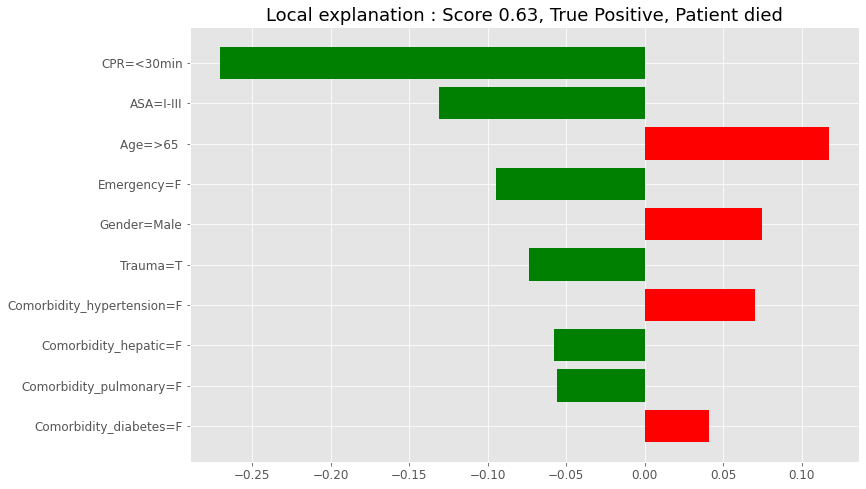

In [41]:
outcome = 1
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

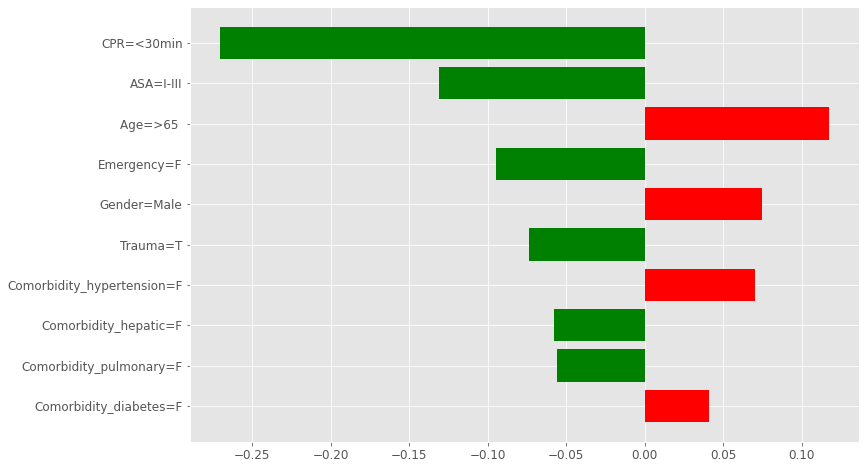

In [42]:
outcome = 1
outcome_title = 'died'
#plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))
plot_vertical_bar(explaination, ''.format(score, score_compare(score, outcome),outcome_title))

In [43]:
test_sample_died_correct = get_test_sample(ensemble_pipeline, seed=43) #, survived=True, correct=True, seed=42
test_sample_died_correct


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
139,0,2,0,0,0,1,1,0,0,1,0,3,1,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0


In [44]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_died_correct)
score = round(result[0,0],2)
score

0.74

Intercept 0.6470854927423405
Prediction_local [0.24137827]
Right: 0.2643823405702326


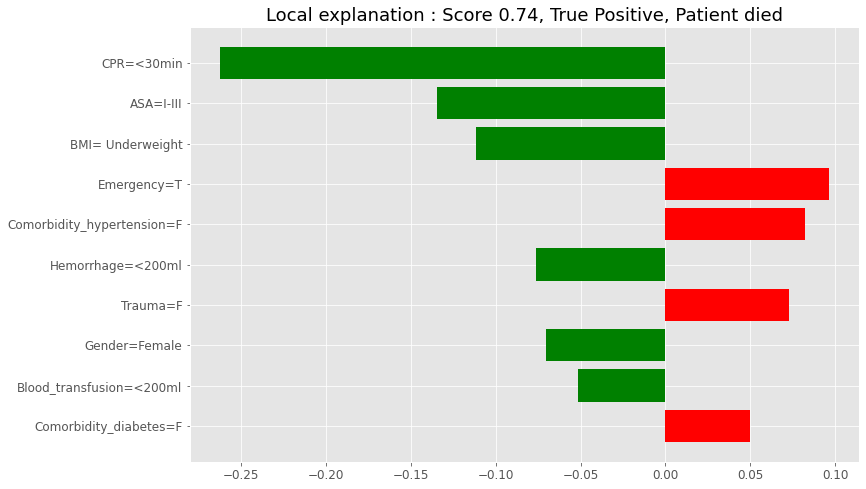

In [45]:
explaination = explainer.explain_instance(test_sample_died_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

Intercept 0.5924266280591591
Prediction_local [0.31494206]
Right: 0.2643823405702326


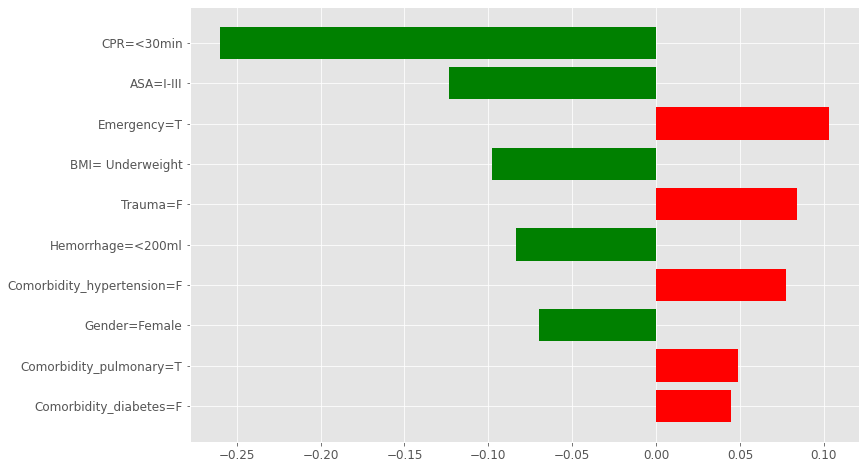

In [46]:
explaination = explainer.explain_instance(test_sample_died_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'died'
plot_vertical_bar(explaination, ''.format(score, score_compare(score, outcome), outcome_title))

In [47]:
test_sample_died_correct = get_test_sample(ensemble_pipeline, died=False, seed=42) 
test_sample_died_correct


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
104,0,1,3,0,0,1,1,0,0,0,0,0,1,0,1,4,1,2,1,1,1,0,2,0,0,0,0,1


In [48]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_died_correct)
score = round(result[0,0],2)
score

0.15

Intercept 0.28204212600819345
Prediction_local [0.87128074]
Right: 0.8459229716164742


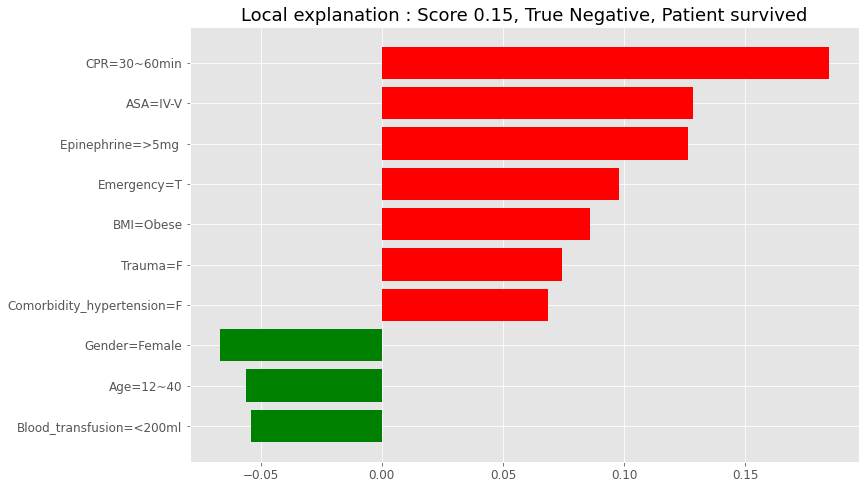

In [49]:
explaination = explainer.explain_instance(test_sample_died_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'survived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

Intercept 0.23493209505496576
Prediction_local [0.9212005]
Right: 0.8459229716164742


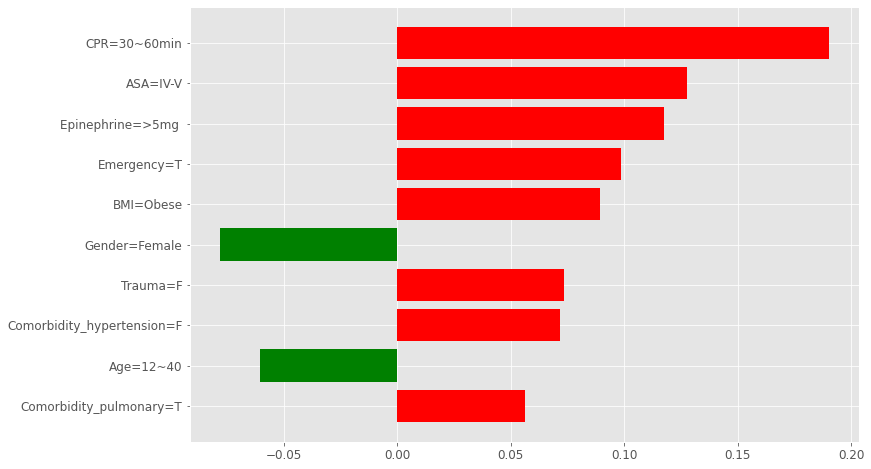

In [50]:
explaination = explainer.explain_instance(test_sample_died_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'survived'
plot_vertical_bar(explaination, ''.format(score, score_compare(score, outcome), outcome_title))

In [51]:
test_sample_died_correct = get_test_sample(ensemble_pipeline, died=False, seed=43) #, correct=True, seed=42
test_sample_died_correct


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
100,0,1,2,0,1,1,1,0,0,0,0,0,1,0,1,4,1,2,0,1,1,0,2,1,0,0,0,2


In [52]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_died_correct)
score = round(result[0,0],2)
score

0.11

Intercept 0.4218458901457337
Prediction_local [0.88029627]
Right: 0.8861207528005293


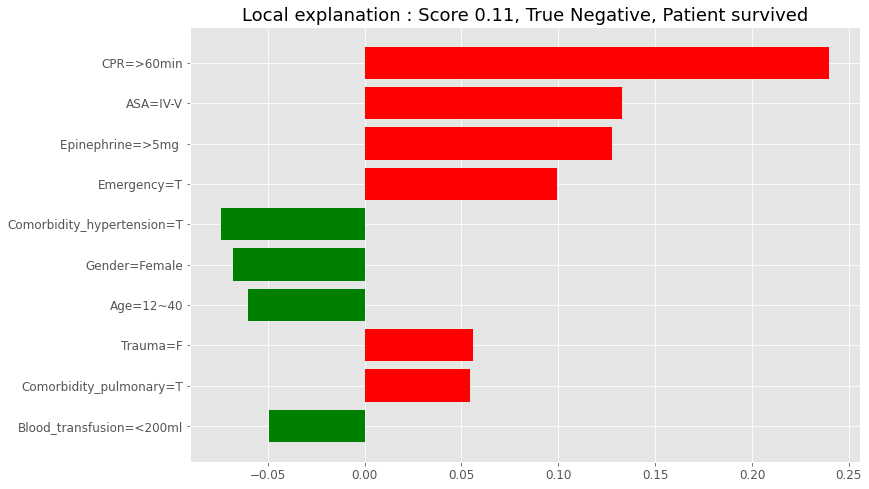

In [53]:
explaination = explainer.explain_instance(test_sample_died_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'survived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

Intercept 0.3628926660260055
Prediction_local [0.90262993]
Right: 0.8861207528005293


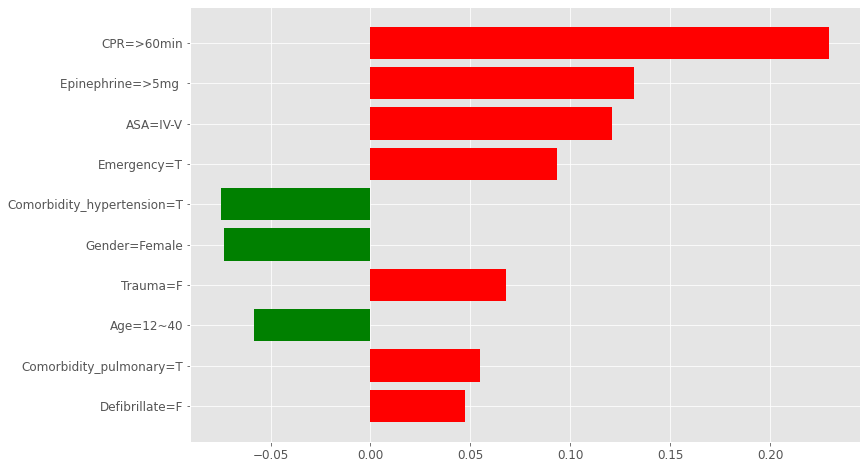

In [54]:
explaination = explainer.explain_instance(test_sample_died_correct.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'survived'
plot_vertical_bar(explaination, ''.format(score, score_compare(score, outcome), outcome_title))

### Incorrect, patient survived, score 69%


In [55]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, died=False, seed=42) #, correct=True, seed=42
test_sample_incorrect


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
111,1,2,1,0,0,1,0,0,0,0,0,3,1,0,1,4,0,2,0,1,0,0,1,0,0,0,0,0


In [56]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.69

Intercept 0.5902648790059337
Prediction_local [0.38636281]
Right: 0.30801218715454615


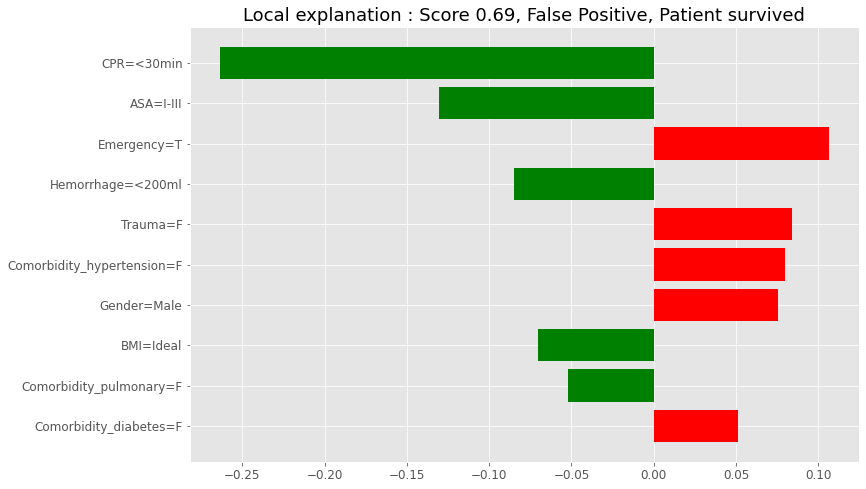

In [58]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'survived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

Intercept 0.5996291607433819
Prediction_local [0.37105201]
Right: 0.30801218715454615


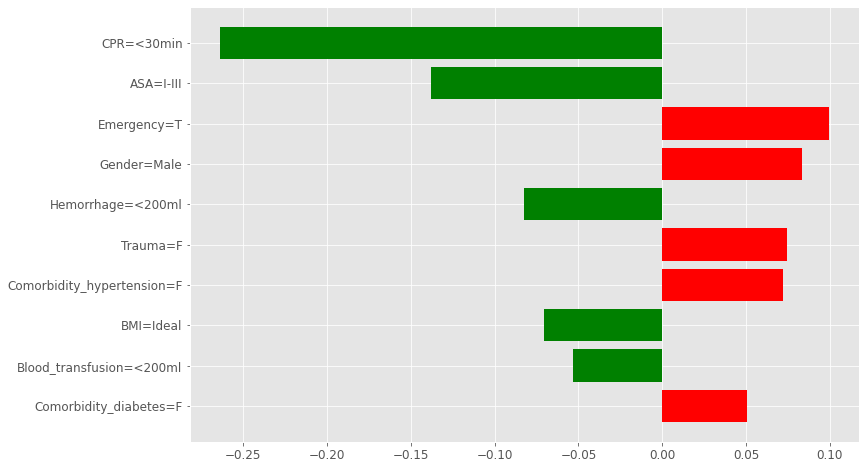

In [59]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'survived'
plot_vertical_bar(explaination, ''.format(score, score_compare(score, outcome), outcome_title))

### Incorrect, patient survived, score 65%


In [60]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, died=False, seed=43) #, correct=True, seed=42
test_sample_incorrect


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
18,1,1,2,0,1,0,0,0,1,0,0,1,1,1,1,4,1,2,1,3,0,2,1,0,0,0,0,0


In [61]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.65

Intercept 0.6427320810296965
Prediction_local [0.37226056]
Right: 0.34763362226493805


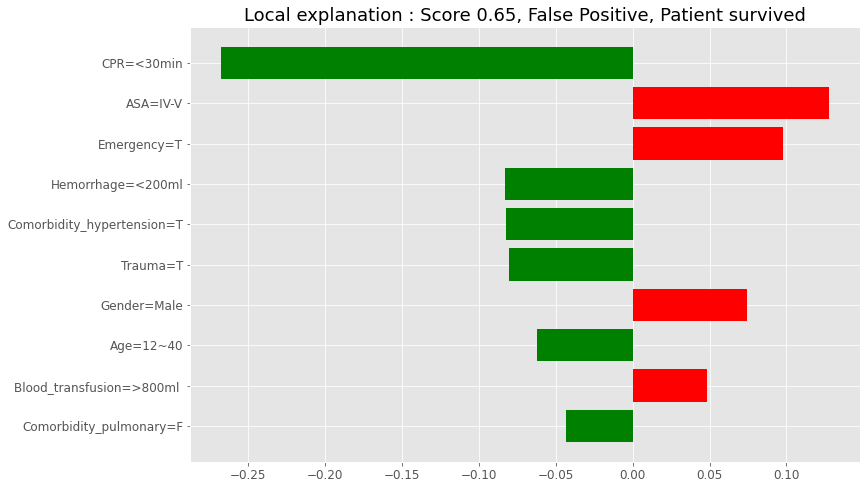

In [62]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 0
outcome_title = 'survived'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

### Incorrect, patient died, score 48%


In [63]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, died=True, seed=42) #, correct=True, seed=42
test_sample_incorrect


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
109,0,1,1,0,0,0,0,0,0,0,0,5,0,0,1,4,0,2,0,3,2,2,1,0,0,0,0,1


In [64]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.48

Intercept 0.5138167772954522
Prediction_local [0.56132606]
Right: 0.5203415450330856


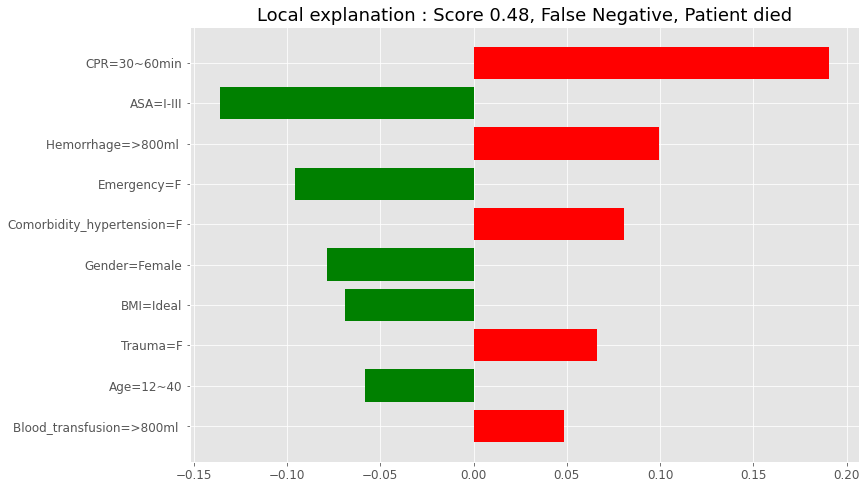

In [65]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

Intercept 0.5293328267092766
Prediction_local [0.56345137]
Right: 0.5203415450330856


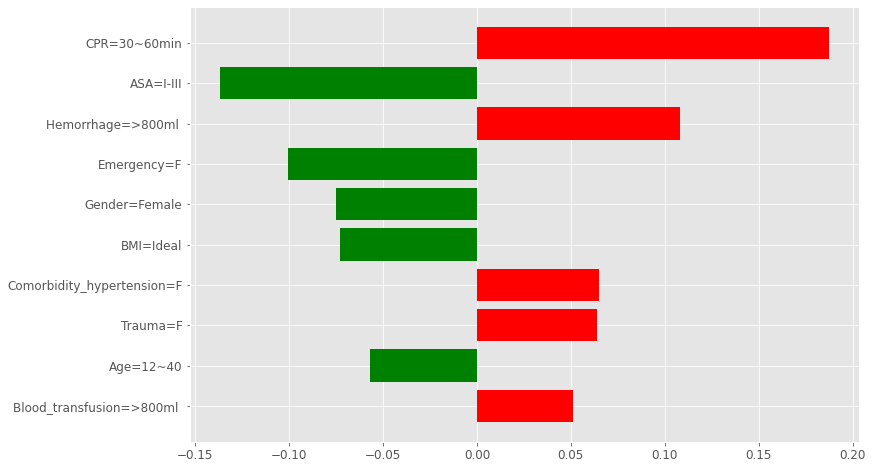

In [66]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'died'
#plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))
plot_vertical_bar(explaination, ''.format(score, score_compare(score, outcome), outcome_title))

### Incorrect, patient died, score 46%


In [64]:
test_sample_incorrect = get_test_sample(ensemble_pipeline, correct=False, died=True, seed=43) #, correct=True, seed=42
test_sample_incorrect


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
126,1,2,3,0,1,1,1,0,0,1,0,5,0,1,1,2,0,2,1,3,2,2,2,1,0,1,1,0


In [65]:
# prediction
result = ensemble_pipeline.predict_proba(test_sample_incorrect)
score = round(result[0,0],2)
score

0.46

Intercept 0.7029431569008867
Prediction_local [0.50380866]
Right: 0.5434647633463567


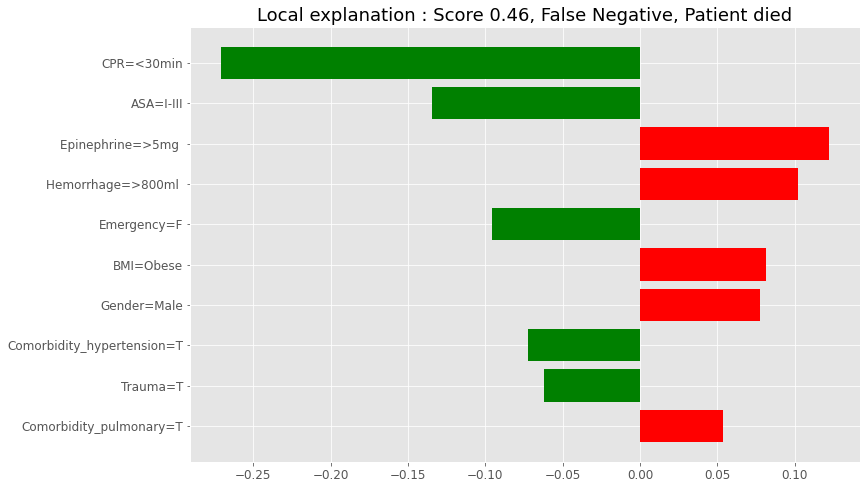

In [66]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'died'
plot_vertical_bar(explaination, 'Local explanation : Score {}, {}, Patient {}'.format(score, score_compare(score, outcome), outcome_title))

Intercept 0.7048667639221549
Prediction_local [0.49752069]
Right: 0.5434647633463567


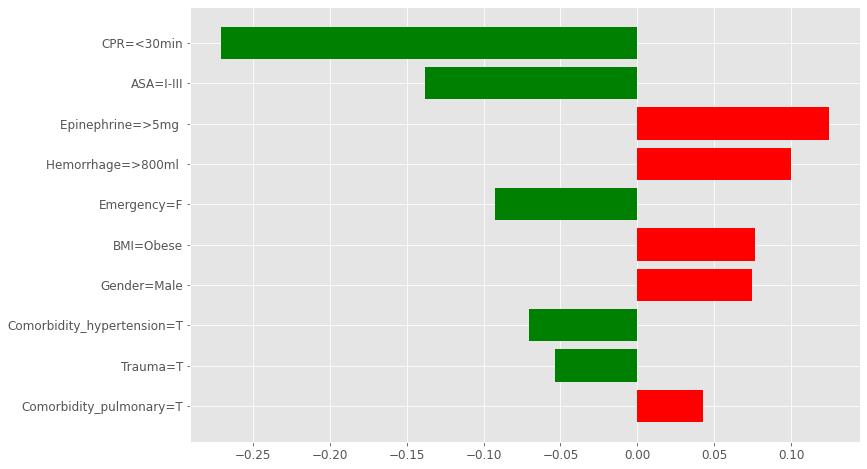

In [67]:
explaination = explainer.explain_instance(test_sample_incorrect.values.ravel(), ensemble_pipeline.predict_proba)
print(explaination)
outcome = 1
outcome_title = 'died'
plot_vertical_bar(explaination, ''.format(score, score_compare(score, outcome), outcome_title))

### Overall explanation by LIME


Intercept 0.7150467207199441
Prediction_local [0.25791351]
Right: 0.255916621386487


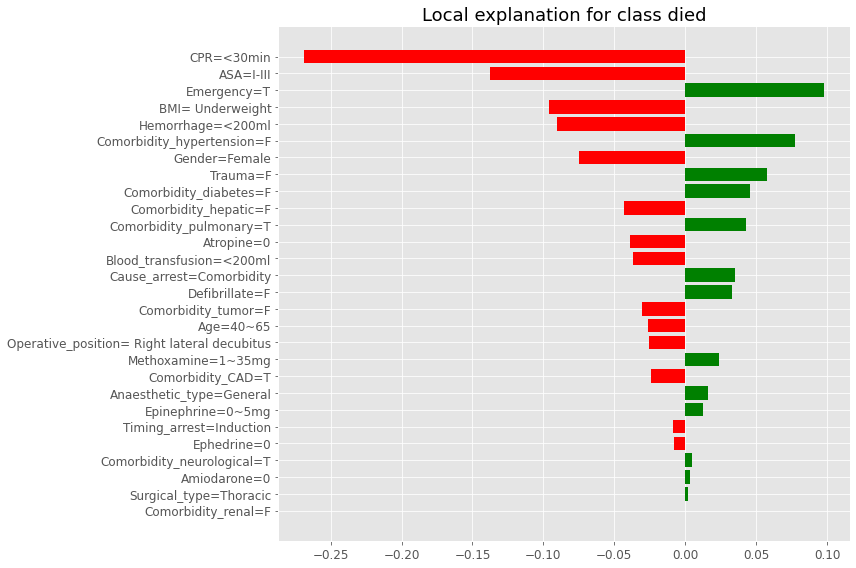

In [68]:
#model =rf_clf
model=ensemble_clf

RANDOM_STATE=123

explainer = LimeTabularExplainer(
    data_train.iloc[:, :-1].values, # remove the target variable from the training set that's fed into LIME
    class_names=['survived','died'],
    feature_names=list(data_train.columns),
    categorical_features=categorical_var_idxs,
    categorical_names=categorical_names,
    mode="classification",
    verbose=True,
    random_state=RANDOM_STATE)


##LIME

#Explain samples in test set
X_explain = data_test.iloc[:, :-1]
#data_test.drop('Died',1)

#Explaining first subject in test set using all 30 features
exp = explainer.explain_instance(X_explain.values[0,:],model.predict_proba, num_features=30)
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

### 3. Preparing a SHAP explainer


In [69]:
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'rb') as f:
    rf_clf = pickle.load(f)
model=rf_clf

In [70]:
#We can also use Shapley force plots to give us additional information on a particular instance.

# explain the model's predictions on test set using SHAP values
# same syntax works for xgboost, LightGBM, CatBoost, and some scikit-learn models
explainer = shap.TreeExplainer(model)

# shap_values consists of a list of two matrices of dimension samplesize x #features
# The first matrix uses average nr of benign samples as base value
# The second matrix which is used below uses average nr of malignant samples as base value 
shap_values = explainer.shap_values(X_explain)


# Interactive visualization of the explanation of the first subject
# in the test set (X_explain).
# It shows the relative contribution of features to get from the base value of malignant
# samples(average value)
# to the output value (1 in case of malignant sample)
# the numbers at the bottom show the actual values for this sample.
shap.initjs() #initialize javascript in cell
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_explain.iloc[0,:])

In [71]:
#Interactive visualization of all sample/feature Shapley values
#It is possible to show the relative contribution of individual features for all
# samples on the y-axis as well.
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_explain)

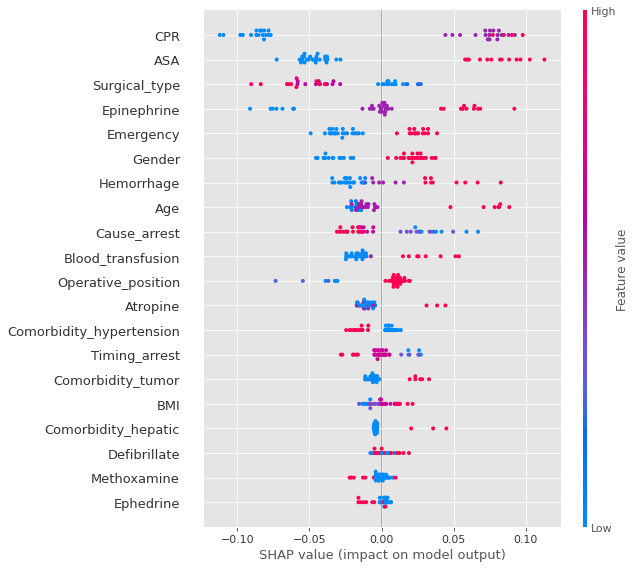

In [72]:
#A summary plot with the shapley value (feature importance) 
shap.summary_plot(shap_values[1], X_explain)

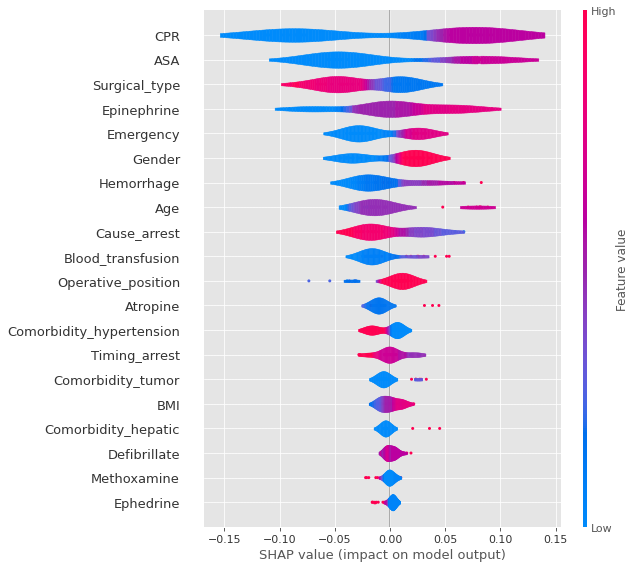

In [73]:
#Same as above, but with violin plots to better see the distribution of shapley values 
shap.summary_plot(shap_values[1], X_explain, plot_type="violin")

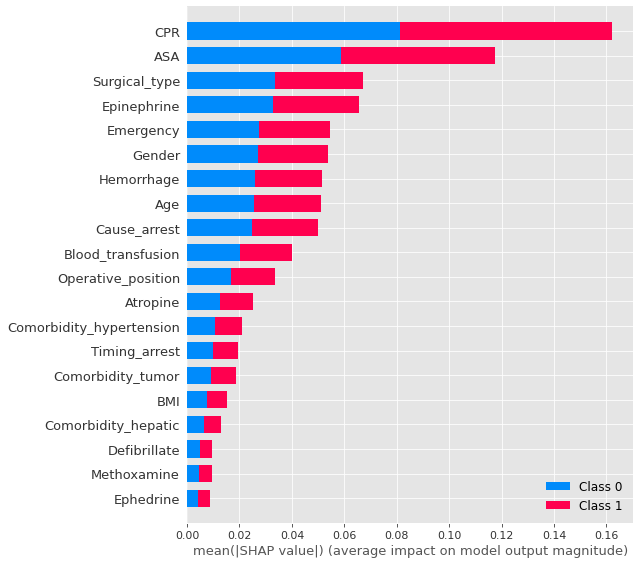

In [74]:
shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('test.png', dpi=300)

### 4. Partial Dependence Plots

Partial Dependency Plots (DPD) show the effect a feature has on the outcome of a predictive based model.
It marginalizes the model output over the distribution of features in order to extract the importance of the feature of interest. This importance calculation is based on an important assumption, namely that the feature of interest is not correlated with all other features (except for the target). The reason for this is that it will show data points that are likely to be impossible. For example, weight and height are correlated but the PDP might show the effect of a large weight and very small height on the target while that combination is highly unlikely. This can be partially resolved by showing a rug at the bottom of your PDP.

https://lmc2179.github.io/posts/pdp.html

In [141]:
from pdpbox import pdp
import seaborn as sns

In [142]:
#data=data_train.drop('Died',1)
df_pdp=data_train_X

In [143]:
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'rb') as f:
    rf_clf = pickle.load(f)
model=rf_clf

#### 4.0 Correlation - One-hot Encoding
Below the correlation matrix is shown between features to give an indication of whether the assumption of independence is violated or not. From these features one can conclude that there seems to be no violation seeing as features are not highly correlated. Here we look into the one-hot encoded features. 

In [144]:
df_pdp.head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,Comorbidity_tumor,Surgical_type,Emergency,Trauma,Anaesthetic_type,Operative_position,ASA,Timing_arrest,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
0,1,2,1,0,1,0,0,0,1,0,0,0,1,0,1,4,1,0,1,0,0,0,1,0,0,0,0,1
1,0,2,3,0,0,0,0,0,0,0,1,0,1,0,1,4,1,2,0,2,2,2,1,0,0,1,0,1
2,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,4,1,3,0,3,1,0,0,0,0,0,0,1
3,1,2,3,0,1,1,1,0,1,1,0,3,1,0,1,4,1,2,1,1,2,2,1,2,0,0,0,1
4,1,2,2,0,1,1,1,1,1,0,0,0,1,0,1,4,1,2,0,1,0,0,2,0,0,0,0,1


<AxesSubplot:>

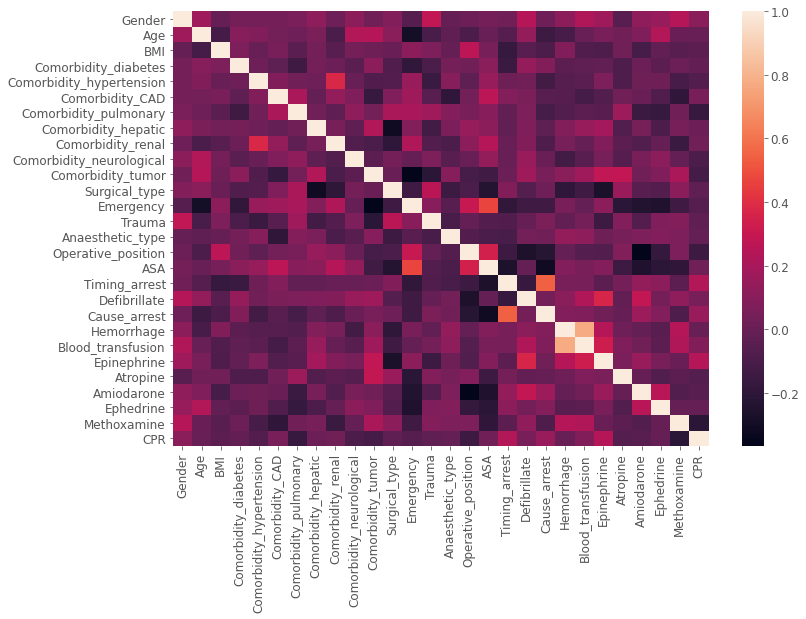

In [145]:
# calculate the correlation matrix
corr = df_pdp.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Then I simply extract the features that have the highest absolute correlation by unstacking the correlation matrix and quicksorting it.

In [146]:
c = df_pdp.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
df_corr = pd.DataFrame(so).reset_index().dropna()
df_corr.columns = ['feature1', 'feature2', 'r']
df_corr = df_corr[df_corr.r < 1].sort_values('r', ascending=False)
df_corr.head(10)

,feature1,feature2,r
755,Hemorrhage,Blood_transfusion,0.774969
754,Blood_transfusion,Hemorrhage,0.774969
753,Timing_arrest,Cause_arrest,0.542557
752,Cause_arrest,Timing_arrest,0.542557
751,ASA,Emergency,0.465754
750,Emergency,ASA,0.465754
749,Comorbidity_renal,Comorbidity_hypertension,0.378397
748,Comorbidity_hypertension,Comorbidity_renal,0.378397
747,Operative_position,Amiodarone,0.367689
746,Amiodarone,Operative_position,0.367689


#### 4.1 PDP - Single feature

The PDP plot for the feature "Age" shows that until the age of 50 there is a higher chance of earning more as a persons age increases. However, after the age of 50 we see this trend going the other direction, namely that age has a negative effect on the likelihood of earning more. 

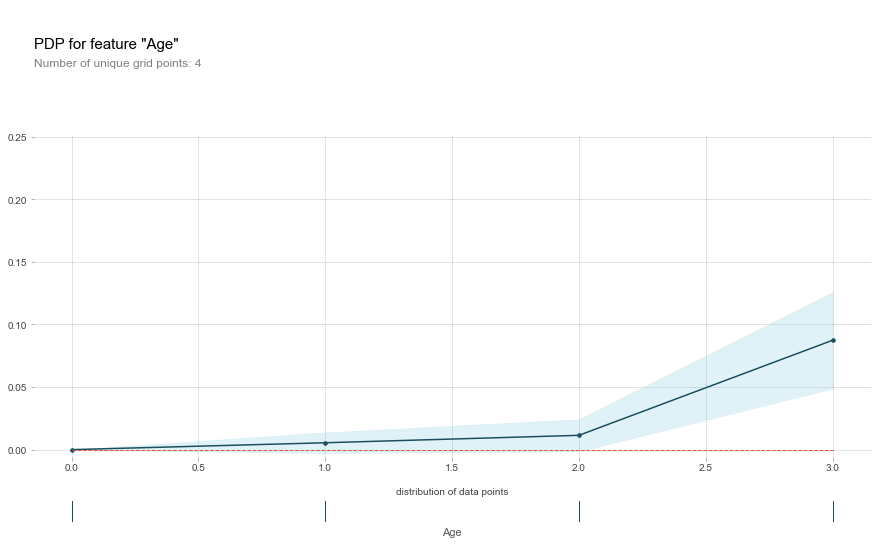

In [148]:
pdp_fare = pdp.pdp_isolate(
    model=rf_clf, dataset=df_pdp[df_pdp.columns[0:28]], model_features=df_pdp.columns[0:28], feature='Age'
)
fig, axes = pdp.pdp_plot(pdp_fare, 'Age', plot_pts_dist=True)